# Sightseeing in New York City
** Extracting patterns from geolocated venues and events **

Machine learning, and in particular clustering algorithms, can be used to determine which geographical areas are commonly visited and “checked into” by a given user and which areas are not. Such geographical analyses enable a wide range of services, from location-based recommenders to advanced security systems, and in general provide a more personalized user experience. 

I will use these techniques to provide two flavours of predicting analytics: 

First, I will build a simple recommender system which will provide the most trending venues in a given area. In particular, k-means tclustering can be applied to the dataset of geolocated events to partition the map into regions. For each region, we can rank the venues which are most visited. With this information, we can recommend venues and landmarks such as Times Square or the Empire State Building depending of the location of the user.

Second, I’ll determine geographical areas that are specific and personal to each user. In particular, I will use a density-based clustering technique such as DBSCAN to extract the areas where a user usually go. This analysis can be used to determine if a given data point is an _outlier_ with respect to the areas where a user normally checks in. And therefore it can be used to score a "novelty" or "anomaly" factor given the location of a given event

We will analyze this events from a public dataset shared by Gowalla on venues checkins registered between 2008 and 2010. This notebook will cover some typical data science steps:

  - data acquisition
  - data preparation
  - data exploration
  
Thereafter, we will dive into some unsupervised learning techniques: *k-means* and *dbscan* clustering, respectively for recommending popular venues and for determining outliers.

## Imports

In [73]:
%matplotlib inline

# utils
import os
import re
import urllib

# images on the notebook
from PIL import Image

# time
import pytz as tz
from datetime import datetime

# cassandra driver
from cassandra.cluster import Cluster
from cassandra.cluster import SimpleStatement, ConsistencyLevel

# data exploration
import numpy as np
np.random.seed(1337)

import pandas as pd

In [74]:
# init
datadir = './data'

# connect to cassandra
CASSANDRA_NODES = [ os.getenv('CASSANDRA_NODE', '127.0.0.1') ]

cluster = Cluster(CASSANDRA_NODES)
session = cluster.connect()

In [75]:
#matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

### Loading events and venues data
Load two cassandra tables and merge them in pandas.

In [76]:
# from database
cql_stmt = """
    SELECT * from lbsn.events;
"""
rows = session.execute(cql_stmt)
dfe = pd.DataFrame(list(rows))

cql_stmt = """
    SELECT * from lbsn.venues;
"""
rows = session.execute(cql_stmt)
dfv = pd.DataFrame(list(rows))

df = pd.DataFrame.merge(dfe,dfv[['vid', 'name']], on='vid', how="inner")
print(df.shape)
df.head(3)

(112383, 6)


uid                  ts        lat        lon     vid      name
0  118712 2010-06-28 13:42:51  40.760333 -73.965363  286922  Felidias
1   33197 2010-05-05 22:52:38  40.760333 -73.965363  286922  Felidias
2    1274 2010-01-25 23:10:16  40.760333 -73.965363  286922  Felidias

### Exploring events on the map

In [77]:
def get_map(x,y,z,size, filename) :
    static_map = "http://staticmap.openstreetmap.de/staticmap.php?center={0},{1}&zoom={2}&size={3}x{3}&maptype=mapnik".format(y,x,z,size)

    static_map_filename, headers = urllib.request.urlretrieve(static_map, filename)
    return static_map_filename

def geomap(data, zoom=13, point_size=3, point_color='r', point_alpha=1):
    #corrections to match geo with static map
    z=zoom
    picsize=1000
    wx = 1.0*360*(picsize/256)/(2**z) 
    wy = 0.76*360*(picsize/256)/(2**z) 

    #center of manhattan
    y = 40.7502
    x = -73.9752

    x_min, x_max = x-wx/2, x+wx/2
    y_min, y_max = y-wy/2, y+wy/2

    static_map_filename = os.path.join(datadir, 'nyc_staticmap_{}_{}.png'.format(z,picsize))

    if os.path.isfile(static_map_filename)==False:
        get_map(x,y,z,picsize,static_map_filename)

    img = Image.open(static_map_filename)

    #add the static map
    plt.imshow(img,zorder=0, extent=[x_min, x_max, y_min, y_max], interpolation='none', aspect='auto')

    #add the scatter plot of events
    plt.plot( 
        data['lon'], 
        data['lat'], 
        '.', 
        markerfacecolor=point_color, 
        markeredgecolor='k', 
        markersize=point_size, 
        alpha=point_alpha)

    #limit the plot to the given box
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)



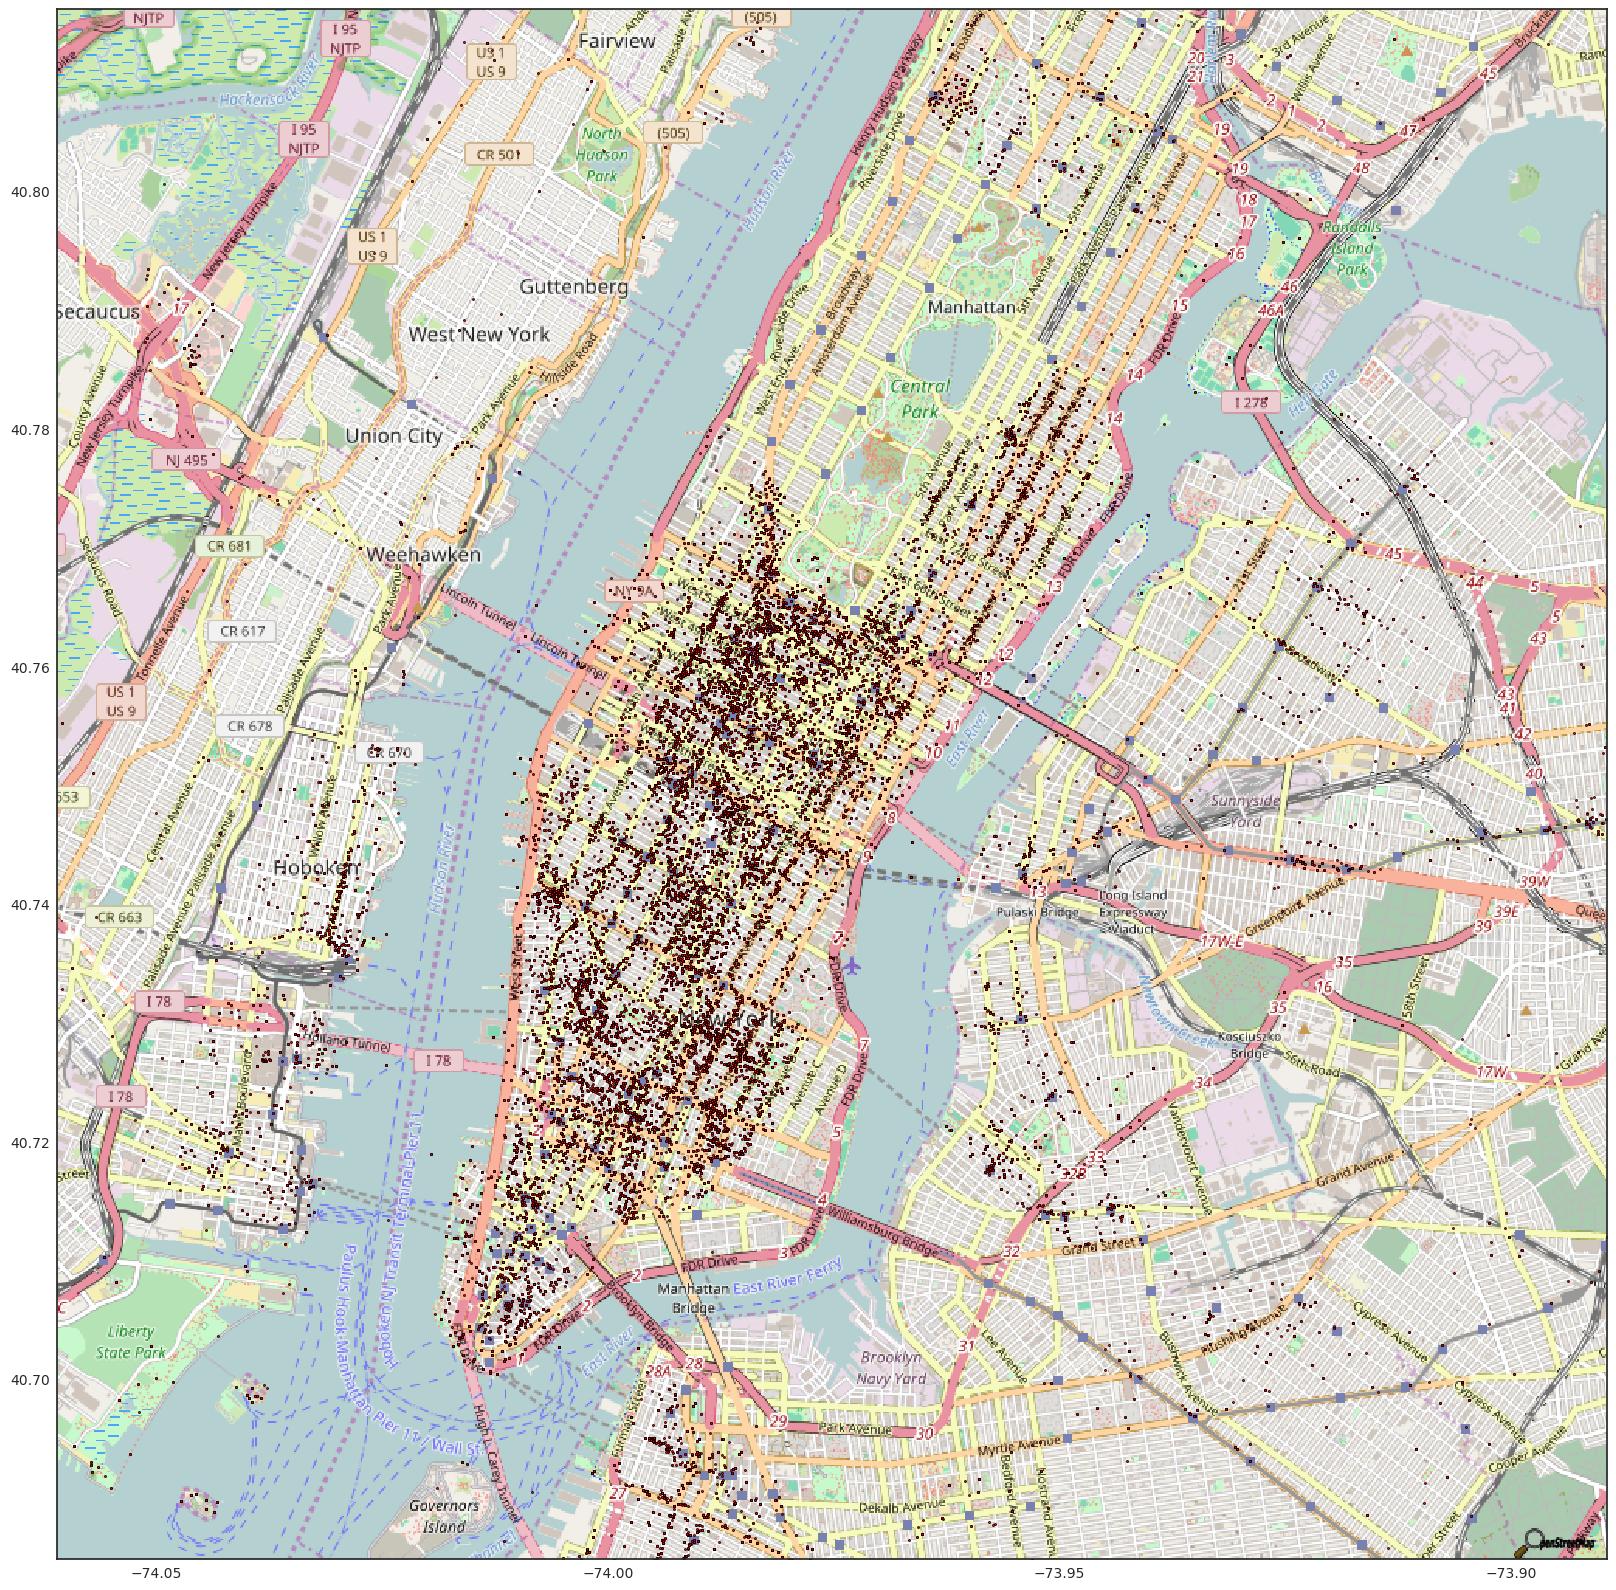

In [78]:
#prepare the figure
plt.style.use('seaborn-white')

fig = plt.figure()
fig.set_size_inches(20,20)

geomap(df[['lon','lat']])

plt.show()

### Machine Learning: k-means clustering

In [79]:
from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics import pairwise_distances

#### Cluster events
Clustering in 2D, using events' lat and lon as variables.   
200 clusters calculated on a 10% sample of the original set.

In [80]:
ml = KMeans(n_clusters=200, init='k-means++')
ml.fit(df[['lon','lat']].sample(frac=0.1))

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=200, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [81]:
clusters = ml.cluster_centers_
clusters[:10]

array([[-73.99941961,  40.74414458],
       [-73.84560202,  40.72236465],
       [-74.17668389,  40.69559994],
       [-73.9272588 ,  40.82660877],
       [-73.98979655,  40.72958161],
       [-74.02877395,  40.90543801],
       [-73.7830772 ,  40.64440803],
       [-73.97728145,  40.68264503],
       [-74.20865339,  40.83194668],
       [-74.14045856,  40.62046437]])

#### Apply clustering
Add cluster id to each event. Now we can group by cluster id.

In [82]:
df['cluster'] = ml.predict(df[['lon','lat']])
df[['uid','lat','lon','vid','name', 'cluster']].sample(10)

uid        lat        lon     vid  \
47168    2439  40.667289 -73.972627  408784   
71179  193814  40.594962 -73.981745  265870   
65417   43395  40.686472 -73.990016  128019   
14905  118439  40.573285 -73.979748  573833   
39947   29353  40.719516 -73.796076  495431   
74591   39975  40.755100 -73.993195   37437   
8632    17720  40.756880 -73.986225   11844   
24413   13309  40.726910 -73.984352  196546   
81700  119198  40.765000 -73.982925  279840   
71172   11991  40.594962 -73.981745  265870   

                                           name  cluster  
47168                 Prospect Park Long Meadow      157  
71179                       L&B Spumoni Gardens      109  
65417  Hanco's Bubble Tea & Vietnamese Sandwich       85  
14905                    Coney Island Boardwalk       18  
39947                              Century Hall      186  
74591                                      R/GA      190  
8632                               Times Square       38  
24413                   Please Don't Tell (PDT)      115  
81700                           Du Art Building       10  
71172                       L&B Spumoni Gardens      109

#### Voronoi maps
Visualize the clusters using a voronoi map overlay on the previous picture

In [83]:
from scipy.spatial import Voronoi

# credits to Pauli Virtanen
# https://gist.github.com/pv/8036995

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

#### Voronoi maps
This image consists of 4 layers, from botton to top:
 - the openstreet map
 - geo-located events (red dots)
 - the voronoi cells (edges are points equi-distant from centroids)
 - voronoi cells' centroids (k-means cluster centers)

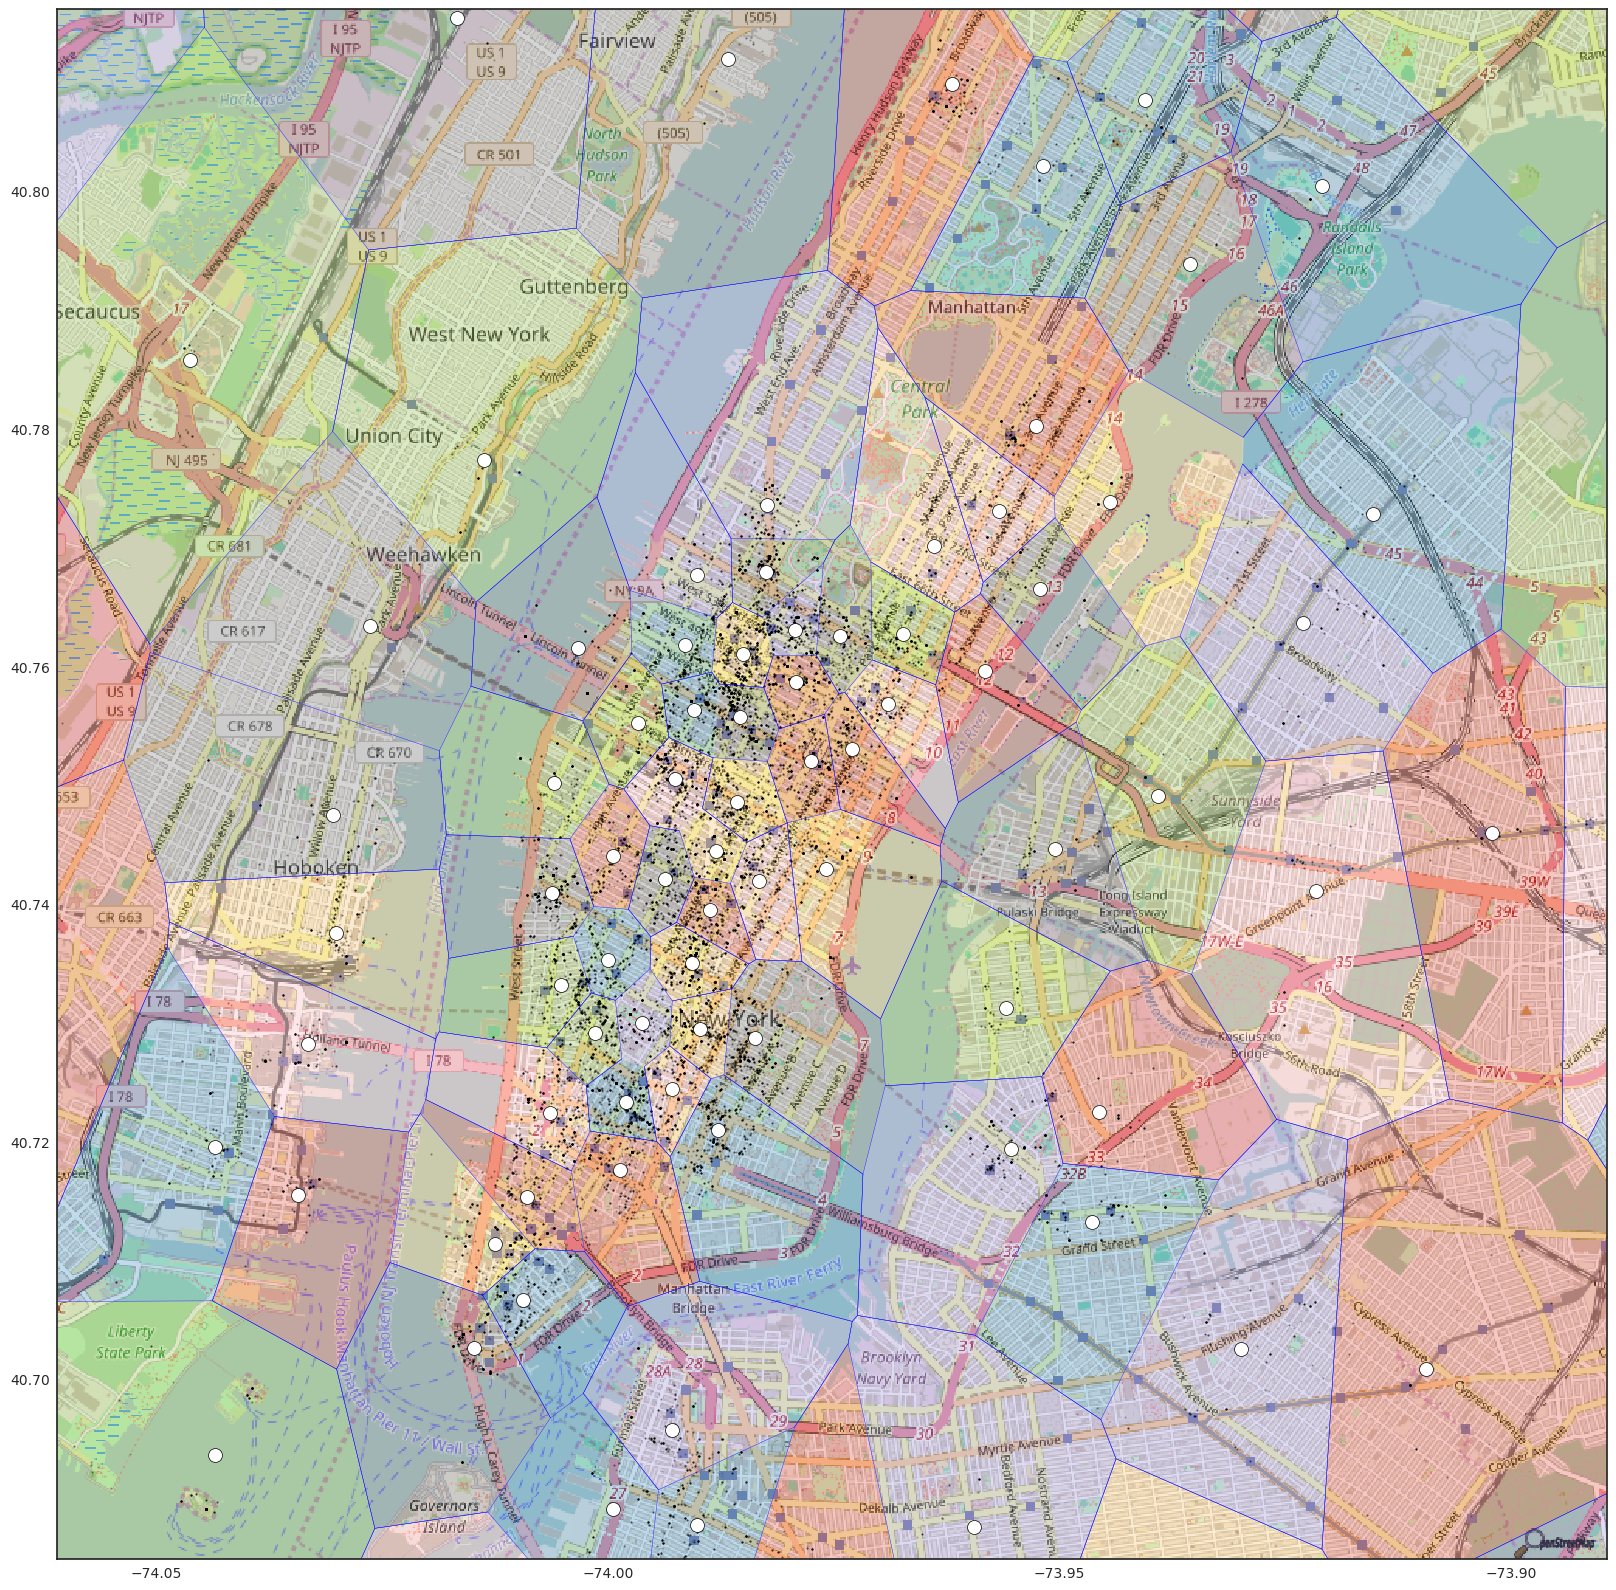

In [84]:
#points = np.array([[c[1], c[0]] for c in clusters])
points = clusters

# compute Voronoi tesselation
vor = Voronoi(points)

# compute regions
regions, vertices = voronoi_finite_polygons_2d(vor)

# prepare figure
plt.style.use('seaborn-white')
fig = plt.figure()
fig.set_size_inches(20,20)

#geomap
geomap(df[['lon','lat']], 13, 2,'k',0.1)

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.3)
    plt.plot(*zip(*polygon), c="b", linewidth=0.3)

# centroids
plt.plot(points[:,0], points[:,1], 'wo',markersize=10)


plt.show()



#### Explore venues in each k-mean cluster

In [85]:
gdf = df.groupby(['cluster', 'vid']).size().reset_index()
gdf.columns = ['cluster', 'vid', 'count']

idx = gdf.groupby(['cluster'])['count'].transform(max) == gdf['count']
topvenues_df = gdf[idx].merge(dfv, on='vid', how='inner').sort_values(by='count', ascending=False)

In [86]:
# guarantee one single venue per cluster
topvenues_df = topvenues_df.groupby('cluster').first()

In [87]:
topvenues_df.reset_index(level=0, inplace=True)
topvenues_df.shape

(200, 6)

In [88]:
#top 10 out of 200 clusters by events count
d = topvenues_df[:10].copy()
d

cluster      vid  count        lat        lon  \
0        0   782184     44  40.745609 -73.998216   
1        1   609838     34  40.726267 -73.852758   
2        2   243314    163  40.695697 -74.177155   
3        3    11720    376  40.829406 -73.927431   
4        4   864730     97  40.730015 -73.991510   
5        5  1338531     57  40.912191 -74.029537   
6        6    23261   1653  40.643885 -73.782806   
7        7    93704     35  40.684381 -73.977063   
8        8   422229     36  40.831903 -74.211354   
9        9  1296227      6  40.636316 -74.143280   

                                name  
0                  NYSC (23rd & 8th)  
1                   Starbucks #07897  
2                     EWR Terminal C  
3                     Yankee Stadium  
4                   Starbucks Coffee  
5                      Retro Fitness  
6  JFK John F. Kennedy International  
7                  Atlantic Terminal  
8                   RHM Headquarters  
9      Staten Island Buddhist Vihara

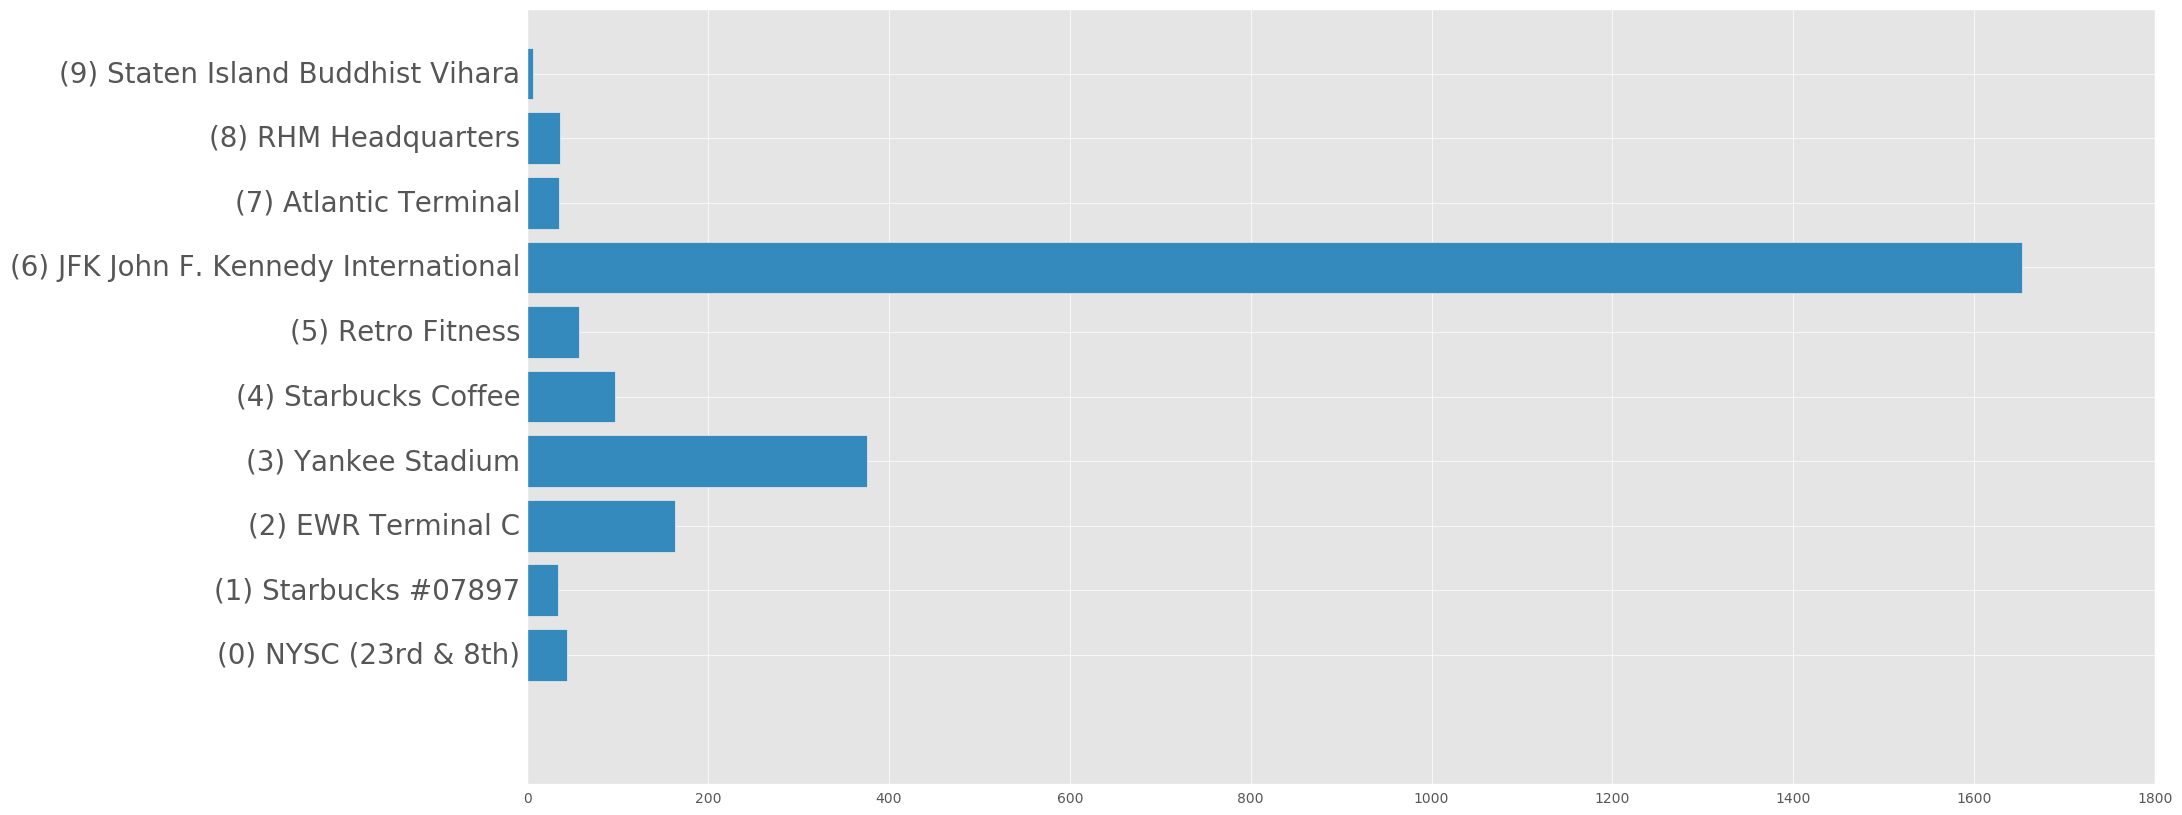

In [89]:
# prepare figure
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,10)

# prefix name with cluster number
d['label'] = d[['cluster', 'name']].apply(lambda x: '({}) {}'.format(int(x[0]), x[1]),axis=1)
plt.barh( range(len(d)), d['count'], align='center')
plt.yticks(range(len(d)),d['label'], fontsize=20)
plt.show()

#### Model Top Venues in Cassandra

In [90]:
session.execute("DROP TABLE IF EXISTS lbsn.kmeans_topvenues");

cql_stmt = """
    CREATE TABLE lbsn.kmeans_topvenues (
      cid    int,
      name   text,
      lat    double,
      lon    double,
      count  bigint,
      url    text,
      PRIMARY KEY (cid)
    );
"""
result = session.execute(cql_stmt)

Store the centroids in cassandra.
We can use a function and apply this row-wise to scan the panda DataFrame

In [91]:
topvenues_df.shape

(200, 6)

In [92]:
#clear the table before inserting data from file
result = session.execute("TRUNCATE lbsn.kmeans_topvenues;")

def insert(x):
    x[1] = x[1].replace("'", "''")
    cql_stmt = """ 
            INSERT INTO lbsn.kmeans_topvenues (cid, name, lat, lon, count) 
                values ({}, '{}', {}, {}, {})""".format(*x)
    
    #print(cql_stmt)
    query = SimpleStatement (cql_stmt,consistency_level=ConsistencyLevel.ONE)
    session.execute(query)

result = topvenues_df[['cluster', 'name', 'lat', 'lon', 'count']].apply(insert,axis=1)

In [93]:
cql_stmt = """
    SELECT * from lbsn.kmeans_topvenues limit 5;
"""
rows = session.execute(cql_stmt)
df = pd.DataFrame(list(rows))
df

cid  count        lat        lon            name   url
0   23      4  40.762872 -73.803921        Sik Gaek  None
1  114     27  40.828992 -74.100075  Station Square  None
2   53    156  40.756425 -73.845420      Citi Field  None
3  110      9  40.872777 -73.896205  Lehman College  None
4   91     32  40.716997 -74.032048   Hyatt Regency  None

### Storing the k-means model in Cassandra

In [94]:
session.execute("DROP TABLE IF EXISTS lbsn.models");

cql_stmt = """
    CREATE TABLE lbsn.models (
      mid    text,
      model  blob,
      PRIMARY KEY (mid)
    );
"""
result = session.execute(cql_stmt)

Use pickle and binascii to save the model as a cassandra blob

In [95]:
import pickle
import binascii

s = pickle.dumps(ml)
s = binascii.hexlify(s).decode('utf-8')

cql_stmt = "INSERT INTO lbsn.models (mid, model) values ('{}', 0x{});".format('kmeans', s)
    
query  = SimpleStatement (cql_stmt,consistency_level=ConsistencyLevel.ONE)
result = session.execute(query)

Get the model back and test it  with:  
`lon:-73.983618, lat:40.753816 Bryant Park`

In [96]:
cql_stmt = "SELECT model from lbsn.models where mid='kmeans'"
rows = session.execute(cql_stmt)
ml_reloaded = pickle.loads(rows[0].model)

In [97]:
location = np.array([-73.983618, 40.753816]).reshape(1, -1)
cluster_id = ml_reloaded.predict(location)[0]

In [98]:
topvenues_df[topvenues_df.cluster==cluster_id]

cluster    vid  count       lat        lon          name
38       38  11844   1089  40.75688 -73.986225  Times Square

In [99]:
ml_reloaded.predict(location)[0] == ml.predict(location)[0]

True